[Nonfinancial Corporate Business; Corporate Equities as a Percentage of Net Worth, Level](https://fred.stlouisfed.org/series/BOGZ1FL103164106A)

[additional](https://www.farooq-javed.com/farooqjaved/2023/7/28/tail-hedging)

[set](https://www.set.or.th/th/market/statistics/market-statistics/main)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Set the font family to Tahoma
plt.rcParams['font.family'] = 'Tahoma'

In [3]:
# Dictionary to map Thai month abbreviations to month numbers
thai_months = {
    "ม.ค.": 1,
    "ก.พ.": 2,
    "มี.ค.": 3,
    "เม.ย.": 4,
    "พ.ค.": 5,
    "มิ.ย.": 6,
    "ก.ค.": 7,
    "ส.ค.": 8,
    "ก.ย.": 9,
    "ต.ค.": 10,
    "พ.ย.": 11,
    "ธ.ค.": 12
}

def convert_thai_date(thai_date):
    # Split the input string
    thai_month_abbr, buddhist_year = thai_date.split("-")
    
    # Convert the Thai month abbreviation to a month number
    month = thai_months[thai_month_abbr.strip()]
    
    # Convert the Buddhist year to Gregorian year
    year = int(buddhist_year.strip())
    if year >= 88:
        year += 1900
    else:
        year += 2000
    # Use the first day of the month for the conversion
    day = 1
    
    # Create a datetime object
    date = datetime(year, month, day)
    
    # Return the formatted date in "Y-M-d" format
    return date.strftime("%Y-%m-%d")

In [4]:
df = pd.read_csv('./Table_PBV.csv', skiprows=3)

In [5]:
df['SET'] = pd.to_numeric(df['SET'], errors='coerce')

In [6]:
selected_df = df[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()

In [7]:
selected_df['Month-Year'] = selected_df['Month-Year'].apply(convert_thai_date)
selected_df['Month-Year'] = pd.to_datetime(selected_df['Month-Year'])

In [8]:
selected_df.set_index('Month-Year', inplace=True)

In [9]:
selected_df['log-SET'] = np.log(selected_df['SET'])

In [10]:
# selected_df['SET'][::-1].cumprod()** (1 / np.arange(1, len(selected_df)+1))
selected_df['gmean-SET'] = np.exp(selected_df['log-SET'].cumsum() / np.arange(1, len(selected_df)+1))

In [11]:
selected_df['scaled-SET'] = selected_df['SET'] / selected_df['gmean-SET'].shift()

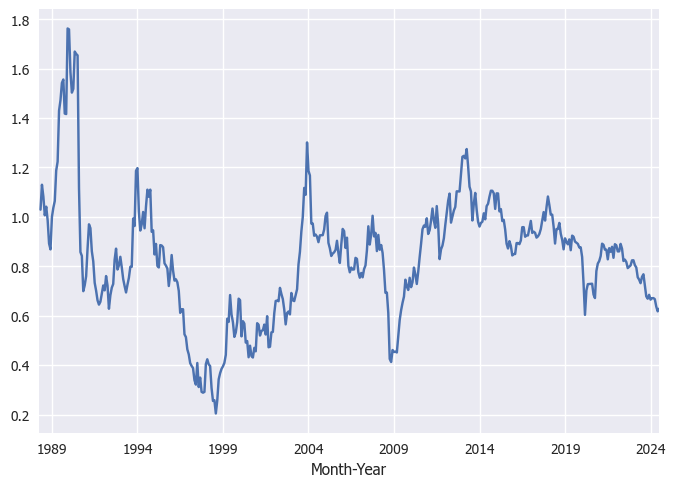

In [12]:
selected_df['scaled-SET'].plot();

In [13]:
selected_df[(selected_df.index.year == 1991) & (selected_df.index.month == 2)]
selected_df[(selected_df.index.year == 2006) & (selected_df.index.month == 9)]
selected_df[(selected_df.index.year == 2014) & (selected_df.index.month == 5)]
selected_df[(selected_df.index.year == 2008) & (selected_df.index.month == 10)]
selected_df[(selected_df.index.year == 1997) & (selected_df.index.month == 7)]
selected_df[(selected_df.index.year == 2020) & (selected_df.index.month == 3)]

,SET,log-SET,gmean-SET,scaled-SET
Month-Year,,,,
2020-03-01,1.23,0.207014,2.035753,0.603405


In [14]:
mask = pd.Series([False] * len(selected_df), index=selected_df.index)

years = [1991, 2006, 2014, 2008, 1997, 2020]
months = [2, 9, 5, 10, 7, 3]
annotations = ['รัฐประหาร 2534', 'รัฐประหาร 2549', 'รัฐประหาร 2557', 'hamburger crisis', 'วิกฤติต้มยำกุ้ง', 'covid-19']
for m, y in zip(months, years):
    mask |= (selected_df.index.year == y) & (selected_df.index.month == m)

In [15]:
selected_df.loc['1991-02']

,SET,log-SET,gmean-SET,scaled-SET
Month-Year,,,,
1991-02-01,3.79,1.332366,4.330381,0.871787


In [16]:
selected_df.loc[f'{y}-{m}', 'scaled-SET'].index

DatetimeIndex(['2020-03-01'], dtype='datetime64[ns]', name='Month-Year', freq=None)

In [17]:
selected_df.loc[f'{y}-{m}', 'scaled-SET']

Month-Year
2020-03-01    0.603405
Name: scaled-SET, dtype: float64

In [18]:
n = 4
selected_df['quarter'], bins = pd.qcut(selected_df['scaled-SET'], q=n, labels=False, retbins=True)

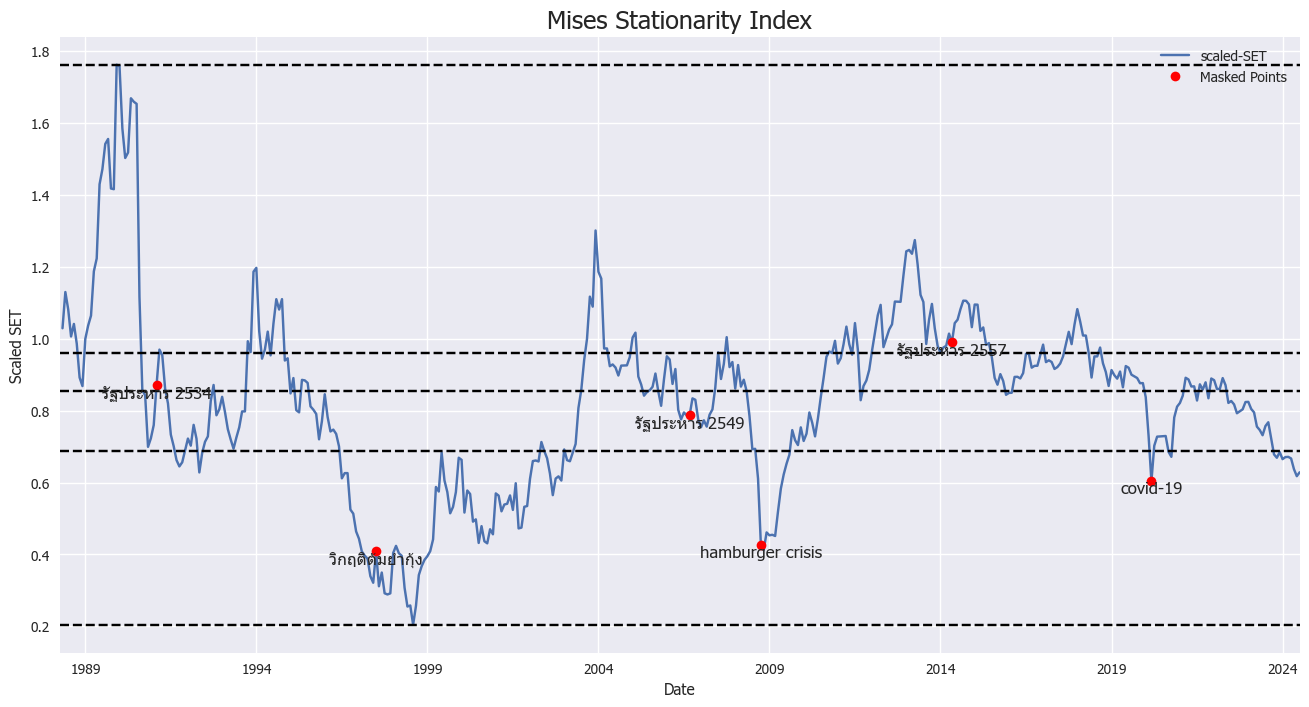

In [19]:
# Plot masked points
plt.figure(figsize=(16, 8))
selected_df['scaled-SET'].plot()
selected_df[mask]['scaled-SET'].plot(style='o', c='red', label='Masked Points')

# Add annotations
for i, (m, y) in enumerate(zip(months, years)):
    index_label = f'{y}-{m}-01'  # Assuming the index is in 'YYYY-MM-DD' format
    if index_label in selected_df.index:
        plt.text(selected_df.loc[index_label].name,  # X position
                 selected_df.loc[index_label, 'scaled-SET'],  # Y position
                 annotations[i], 
                 fontsize=12, 
                 ha='center',
                 va='top')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Scaled SET')
plt.title('Mises Stationarity Index', fontsize=18)
plt.legend()
# plt.axhline(y = 1, color = 'k', linestyle = '--') 
for b in bins:
    plt.axhline(y = b, color = 'k', linestyle = '--') 
# Show the plot
plt.savefig('crisis-analyze-set.png')
plt.show()